In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.model_selection import train_test_split
%matplotlib inline
warnings.filterwarnings("ignore")
plt.style.use('seaborn-whitegrid')

# Set seeds to make the experiment more reproducible.
from numpy.random import seed
seed(1)

interseting = pd.read_excel("/content/drive/MyDrive/DATA/interesting.xlsx", engine='openpyxl')
coordinate = pd.read_excel("/content/drive/MyDrive/DATA/coordinate.xlsx", engine='openpyxl')
index_seoul = coordinate[coordinate['시도']=='서울특별시'].index
coordinate = coordinate.loc[index_seoul,:]
coordinate.drop(['코드종류','하위'], axis= 1, inplace = True)

def data_control(x):
    x = x.reset_index()
    x.drop('여자70세이상생활인구수', axis = 1, inplace = True)
    x.columns = ['기준일ID', '시간대구분', '행정동코드', '총생활인구수', '남자0세부터9세생활인구수',
                 '남자10세부터14세생활인구수', '남자15세부터19세생활인구수', '남자20세부터24세생활인구수',
                 '남자25세부터29세생활인구수', '남자30세부터34세생활인구수', '남자35세부터39세생활인구수',
                 '남자40세부터44세생활인구수', '남자45세부터49세생활인구수', '남자50세부터54세생활인구수',
                 '남자55세부터59세생활인구수', '남자60세부터64세생활인구수', '남자65세부터69세생활인구수', '남자70세이상생활인구수',
                 '여자0세부터9세생활인구수', '여자10세부터14세생활인구수', '여자15세부터19세생활인구수',
                 '여자20세부터24세생활인구수', '여자25세부터29세생활인구수', '여자30세부터34세생활인구수',
                 '여자35세부터39세생활인구수', '여자40세부터44세생활인구수', '여자45세부터49세생활인구수',
                 '여자50세부터54세생활인구수', '여자55세부터59세생활인구수', '여자60세부터64세생활인구수',
                 '여자65세부터69세생활인구수', '여자70세이상생활인구수']
    
    x['행정동코드'] = x['행정동코드'].apply(lambda x : x * 100 )
    x_new = x.merge(coordinate, left_on = '행정동코드', right_on='코드', how = 'left')
    x_new.dropna(axis = 0, inplace = True)
    x_new['Datetime'] = x_new[['기준일ID','시간대구분']].apply(lambda x: ' '.join(x.values.astype(str)), axis=1)
    x_new['Datetime'] = x_new['Datetime'].apply(lambda x : str(x)+'0:00:00' if len(str(x)) == 1 else str(x)+':00:00')
    x_new['Datetime'] = pd.to_datetime(x_new['Datetime'])
    x_new.drop(columns = ['행정동코드','코드','시도','기준일ID','시간대구분','위도','경도'], axis = 1, inplace = True)
    x_new = x_new.groupby(['시군구','읍면동','Datetime']).mean()
    
    return x_new
    
popl_7 = data_control(pd.read_csv("/content/drive/MyDrive/DATA/popl_7.csv"))
popl_6 = data_control(pd.read_csv("/content/drive/MyDrive/DATA/popl_6.csv"))
popl_5 = data_control(pd.read_csv("/content/drive/MyDrive/DATA/popl_5.csv"))
popl_4 = data_control(pd.read_csv("/content/drive/MyDrive/DATA/popl_4.csv"))
popl_3 = data_control(pd.read_csv("/content/drive/MyDrive/DATA/popl_3.csv"))
popl_2 = data_control(pd.read_csv("/content/drive/MyDrive/DATA/popl_2.csv"))
popl_1 = data_control(pd.read_csv("/content/drive/MyDrive/DATA/popl_1.csv"))
popl_ly10 = data_control(pd.read_csv("/content/drive/MyDrive/DATA/popl_ly10.csv"))
popl_ly11 = data_control(pd.read_csv("/content/drive/MyDrive/DATA/popl_ly11.csv"))
popl_ly12 = data_control(pd.read_csv("/content/drive/MyDrive/DATA/popl_ly12.csv"))
popl_ly8 = data_control(pd.read_csv("/content/drive/MyDrive/DATA/popl_ly8.csv"))
popl_ly9 = data_control(pd.read_csv("/content/drive/MyDrive/DATA/popl_ly9.csv"))
popl_8 = data_control(pd.read_csv("/content/drive/MyDrive/DATA/popl_8.csv"))

In [3]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib
import pandas as pd
import os
import numpy as np
from sklearn.metrics import r2_score
plt.style.use('seaborn-whitegrid')

%matplotlib inline
def data_pr(df):
    df2 = df.copy()
    df2 = df2.reset_index()
    df2.loc[(df2['시군구']=='관악구') & (df2['읍면동']=='신사동'),'읍면동']= '관악'+df2.loc[(df2['시군구']=='관악구') & (df2['읍면동']=='신사동'),'읍면동']
    df2.drop(columns = ['시군구', '총생활인구수'], axis = 1, inplace = True)
    df2 = df2.set_index('Datetime')
    df2['M-Infant'] = df2['남자0세부터9세생활인구수']
    df2['W-Infant'] = df2['여자0세부터9세생활인구수']
    df2['M-Seventies'] = df2['남자70세이상생활인구수']
    df2['W-Seventies'] = df2['여자70세이상생활인구수']
    df_rest = df2[['M-Infant','W-Infant','M-Seventies','W-Seventies','읍면동']]
    df2.drop(columns = ['남자0세부터9세생활인구수','여자0세부터9세생활인구수','남자70세이상생활인구수'
                  ,'여자70세이상생활인구수','M-Infant','W-Infant','M-Seventies','W-Seventies','읍면동'], axis = 1, inplace = True)
    
    new_columns = ['M-Teen','M-Twenties','M-Thirties','M-Fourties','M-Fifties','M-Sixties',
             'W-Teen','W-Twenties','W-Thirties','W-Fourties','W-Fifties','W-Sixties']
    
    a = 0
    b = 2
    for i in new_columns:
        df2[i] = df2.iloc[:, a:b].sum(axis=1)
        a += 2
        b += 2
    df2.drop(columns = ['남자10세부터14세생활인구수', '남자15세부터19세생활인구수', '남자20세부터24세생활인구수',
       '남자25세부터29세생활인구수', '남자30세부터34세생활인구수', '남자35세부터39세생활인구수',
       '남자40세부터44세생활인구수', '남자45세부터49세생활인구수', '남자50세부터54세생활인구수',
       '남자55세부터59세생활인구수', '남자60세부터64세생활인구수', '남자65세부터69세생활인구수',
       '여자10세부터14세생활인구수', '여자15세부터19세생활인구수', '여자20세부터24세생활인구수',
       '여자25세부터29세생활인구수', '여자30세부터34세생활인구수', '여자35세부터39세생활인구수',
       '여자40세부터44세생활인구수', '여자45세부터49세생활인구수', '여자50세부터54세생활인구수',
       '여자55세부터59세생활인구수', '여자60세부터64세생활인구수', '여자65세부터69세생활인구수'], axis =1, inplace = True)
    df2 = pd.concat([df2, df_rest], axis = 1)
    return df2

popl_1= data_pr(popl_1)
popl_2= data_pr(popl_2)
popl_3= data_pr(popl_3)
popl_4= data_pr(popl_4)
popl_5= data_pr(popl_5)
popl_6= data_pr(popl_6)
popl_7 = data_pr(popl_7)
popl_8 = data_pr(popl_8)
popl_ly10 = data_pr(popl_ly10)
popl_ly11 = data_pr(popl_ly11)
popl_ly12 = data_pr(popl_ly12)
popl_ly8 = data_pr(popl_ly8)
popl_ly9 = data_pr(popl_ly9)

In [28]:
train_array = [popl_ly8, popl_ly9, popl_ly10, popl_ly11, popl_ly12, popl_1, popl_2, popl_3, popl_4, popl_5, popl_6, popl_7, popl_8]
for i in range(1, len(train_array)):
    popl_ly8 = pd.concat([popl_ly8, train_array[i]], axis = 0)
train_set = popl_ly8
test_set = popl_8

In [29]:
train_set = train_set[train_set['읍면동']=='개포2동']['M-Teen']
test_set = test_set[test_set['읍면동']=='개포2동']['M-Teen']
# train_set = train_set.resample('24h').sum()
# test_set = test_set.resample('24h').sum()
train_df = pd.DataFrame(data = train_set.values, index = train_set.index, columns = ['M-Teen'])
test_df = pd.DataFrame(data = test_set.values, index = test_set.index, columns = ['M-Teen'])
train_df = np.log1p(train_df)
#expm1 하거라 경덕아

In [38]:
def lstm_df(data, window=1, lag=1, dropnan=True):
    val, col_name = list(), list()
    for i in range(window, 0, -1):
        val.append(data.shift(i))
        col_name += [('%s(t-%d)' % ('M-Teen', i))]
    val.append(data)
    col_name += [('%s(t)' % ('M-Teen'))]
    val.append(data.shift(-lag))
    col_name += [('%s(t+%d)' % ('M-Teen', lag))]
    agg = pd.concat(val, axis=1)
    agg.columns = col_name
    if dropnan:
        agg.dropna(inplace=True)
    return agg
window = 72
lag = 30 *24
get_set_ready = lstm_df(train_df, window=window, lag=lag)
get_set_ready.tail()

,M-Teen(t-72),M-Teen(t-71),M-Teen(t-70),M-Teen(t-69),M-Teen(t-68),M-Teen(t-67),M-Teen(t-66),M-Teen(t-65),M-Teen(t-64),M-Teen(t-63),...,M-Teen(t-8),M-Teen(t-7),M-Teen(t-6),M-Teen(t-5),M-Teen(t-4),M-Teen(t-3),M-Teen(t-2),M-Teen(t-1),M-Teen(t),M-Teen(t+720)
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-08-01 19:00:00,7.279101,7.355181,7.427406,7.542471,7.518538,7.569716,7.569518,7.566694,7.592533,7.546970,...,7.362955,7.371885,7.351731,7.335610,7.375461,7.363169,7.402701,7.389221,7.411349,7.590779
2022-08-01 20:00:00,7.355181,7.427406,7.542471,7.518538,7.569716,7.569518,7.566694,7.592533,7.546970,7.547253,...,7.371885,7.351731,7.335610,7.375461,7.363169,7.402701,7.389221,7.411349,7.420544,7.643980
2022-08-01 21:00:00,7.427406,7.542471,7.518538,7.569716,7.569518,7.566694,7.592533,7.546970,7.547253,7.577267,...,7.351731,7.335610,7.375461,7.363169,7.402701,7.389221,7.411349,7.420544,7.465878,7.625304
2022-08-01 22:00:00,7.542471,7.518538,7.569716,7.569518,7.566694,7.592533,7.546970,7.547253,7.577267,7.565146,...,7.335610,7.375461,7.363169,7.402701,7.389221,7.411349,7.420544,7.465878,7.589904,7.706406
2022-08-01 23:00:00,7.518538,7.569716,7.569518,7.566694,7.592533,7.546970,7.547253,7.577267,7.565146,7.524714,...,7.375461,7.363169,7.402701,7.389221,7.411349,7.420544,7.465878,7.589904,7.578530,7.629147


In [40]:
def lstm_df_confirm(data, window=1, lag=1, dropnan=True):
    val, col_name = list(), list()
    for i in range(window, 0, -1):
        val.append(data.shift(i))
        col_name += [('%s(t-%d)' % ('M-Teen', i))]
    val.append(data)
    col_name += [('%s(t)' % ('M-Teen'))]
    val.append(data.shift(-lag))
    col_name += [('%s(t+%d)' % ('M-Teen', lag))]
    agg = pd.concat(val, axis=1)
    agg.columns = col_name
    if dropnan:
        agg.dropna(inplace=True)
    return agg
window = 72
lag = 30 * 24
train_df_confirm = train_df.reset_index()
get_set = lstm_df_confirm(train_df_confirm.drop('M-Teen', axis = 1), window=window, lag=lag)
get_set.tail()

,M-Teen(t-72),M-Teen(t-71),M-Teen(t-70),M-Teen(t-69),M-Teen(t-68),M-Teen(t-67),M-Teen(t-66),M-Teen(t-65),M-Teen(t-64),M-Teen(t-63),...,M-Teen(t-8),M-Teen(t-7),M-Teen(t-6),M-Teen(t-5),M-Teen(t-4),M-Teen(t-3),M-Teen(t-2),M-Teen(t-1),M-Teen(t),M-Teen(t+720)
17539,2022-07-29 19:00:00,2022-07-29 20:00:00,2022-07-29 21:00:00,2022-07-29 22:00:00,2022-07-29 23:00:00,2022-07-30 00:00:00,2022-07-30 01:00:00,2022-07-30 02:00:00,2022-07-30 03:00:00,2022-07-30 04:00:00,...,2022-08-01 11:00:00,2022-08-01 12:00:00,2022-08-01 13:00:00,2022-08-01 14:00:00,2022-08-01 15:00:00,2022-08-01 16:00:00,2022-08-01 17:00:00,2022-08-01 18:00:00,2022-08-01 19:00:00,2022-08-31 19:00:00
17540,2022-07-29 20:00:00,2022-07-29 21:00:00,2022-07-29 22:00:00,2022-07-29 23:00:00,2022-07-30 00:00:00,2022-07-30 01:00:00,2022-07-30 02:00:00,2022-07-30 03:00:00,2022-07-30 04:00:00,2022-07-30 05:00:00,...,2022-08-01 12:00:00,2022-08-01 13:00:00,2022-08-01 14:00:00,2022-08-01 15:00:00,2022-08-01 16:00:00,2022-08-01 17:00:00,2022-08-01 18:00:00,2022-08-01 19:00:00,2022-08-01 20:00:00,2022-08-31 20:00:00
17541,2022-07-29 21:00:00,2022-07-29 22:00:00,2022-07-29 23:00:00,2022-07-30 00:00:00,2022-07-30 01:00:00,2022-07-30 02:00:00,2022-07-30 03:00:00,2022-07-30 04:00:00,2022-07-30 05:00:00,2022-07-30 06:00:00,...,2022-08-01 13:00:00,2022-08-01 14:00:00,2022-08-01 15:00:00,2022-08-01 16:00:00,2022-08-01 17:00:00,2022-08-01 18:00:00,2022-08-01 19:00:00,2022-08-01 20:00:00,2022-08-01 21:00:00,2022-08-31 21:00:00
17542,2022-07-29 22:00:00,2022-07-29 23:00:00,2022-07-30 00:00:00,2022-07-30 01:00:00,2022-07-30 02:00:00,2022-07-30 03:00:00,2022-07-30 04:00:00,2022-07-30 05:00:00,2022-07-30 06:00:00,2022-07-30 07:00:00,...,2022-08-01 14:00:00,2022-08-01 15:00:00,2022-08-01 16:00:00,2022-08-01 17:00:00,2022-08-01 18:00:00,2022-08-01 19:00:00,2022-08-01 20:00:00,2022-08-01 21:00:00,2022-08-01 22:00:00,2022-08-31 22:00:00
17543,2022-07-29 23:00:00,2022-07-30 00:00:00,2022-07-30 01:00:00,2022-07-30 02:00:00,2022-07-30 03:00:00,2022-07-30 04:00:00,2022-07-30 05:00:00,2022-07-30 06:00:00,2022-07-30 07:00:00,2022-07-30 08:00:00,...,2022-08-01 15:00:00,2022-08-01 16:00:00,2022-08-01 17:00:00,2022-08-01 18:00:00,2022-08-01 19:00:00,2022-08-01 20:00:00,2022-08-01 21:00:00,2022-08-01 22:00:00,2022-08-01 23:00:00,2022-08-31 23:00:00


In [41]:
labels_col = 'M-Teen(t+%d)' % lag
x_tr, x_val, y_tr, y_val = train_test_split(get_set_ready.drop(columns =[labels_col], axis = 1), get_set_ready[labels_col], test_size = 0.4, shuffle=False)
X_train_pr = x_tr.values.reshape((x_tr.shape[0], x_tr.shape[1], 1))
X_valid_pr = x_val.values.reshape((x_val.shape[0], x_val.shape[1], 1))

In [42]:
y_val

Datetime
2021-10-14 19:00:00    7.401876
2021-10-14 20:00:00    7.420982
2021-10-14 21:00:00    7.489387
2021-10-14 22:00:00    7.552388
2021-10-14 23:00:00    7.353866
                         ...   
2022-08-01 19:00:00    7.590779
2022-08-01 20:00:00    7.643980
2022-08-01 21:00:00    7.625304
2022-08-01 22:00:00    7.706406
2022-08-01 23:00:00    7.629147
Name: M-Teen(t+720), Length: 6989, dtype: float64

In [43]:
from tensorflow import keras
from keras.layers import Dropout
import tensorflow as tf 
epochs = 40
batch = 256
lr = 0.002
adam = tf.optimizers.Adam(lr)
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, activation = 'relu', input_shape=(X_train_pr.shape[1], X_train_pr.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))
model_lstm.compile(loss = 'mse', optimizer = adam)

In [44]:
lstm = model_lstm.fit(X_train_pr, y_tr, validation_data = (X_valid_pr, y_val), epochs=30, verbose = 2)

Epoch 1/30
328/328 - 39s - loss: 10.6875 - val_loss: 0.1278 - 39s/epoch - 118ms/step
Epoch 2/30
328/328 - 37s - loss: 1.2635 - val_loss: 0.0926 - 37s/epoch - 112ms/step
Epoch 3/30
328/328 - 37s - loss: 1.0677 - val_loss: 0.0841 - 37s/epoch - 112ms/step
Epoch 4/30
328/328 - 39s - loss: 0.9669 - val_loss: 0.0830 - 39s/epoch - 119ms/step
Epoch 5/30
328/328 - 37s - loss: 0.8809 - val_loss: 0.0700 - 37s/epoch - 112ms/step
Epoch 6/30
328/328 - 37s - loss: 0.8411 - val_loss: 0.1154 - 37s/epoch - 112ms/step
Epoch 7/30
328/328 - 36s - loss: 0.7710 - val_loss: 0.0818 - 36s/epoch - 111ms/step
Epoch 8/30
328/328 - 36s - loss: 0.7341 - val_loss: 0.1120 - 36s/epoch - 110ms/step
Epoch 9/30
328/328 - 38s - loss: 0.7058 - val_loss: 0.0559 - 38s/epoch - 115ms/step
Epoch 10/30
328/328 - 36s - loss: 0.6626 - val_loss: 0.0543 - 36s/epoch - 109ms/step
Epoch 11/30
328/328 - 35s - loss: 0.6575 - val_loss: 0.0525 - 35s/epoch - 108ms/step
Epoch 12/30
328/328 - 36s - loss: 0.5999 - val_loss: 0.0530 - 36s/epoch -

Text(0.5, 1.0, 'r2 score : -0.047551651449110555')

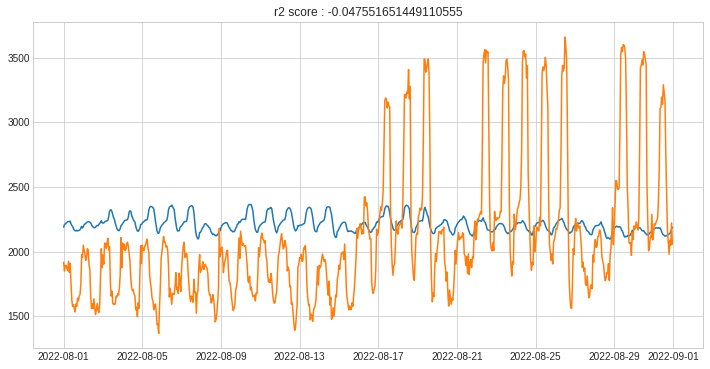

In [45]:
lstm_pred= model_lstm.predict(X_valid_pr)
pred_df = pd.DataFrame(data = lstm_pred[-(24*31):], index = test_set.index, columns = ['M-Teen_pr'])
pred_df['M-Teen_pr'] = np.expm1(pred_df['M-Teen_pr'])
r2 = r2_score(test_set.values, pred_df.values)
fig, ax = plt.subplots(figsize = (12,6))
plt.plot(pred_df)
plt.plot(test_set)
plt.title('r2 score : {0}'.format(r2))

# 한계점:
1. 모델링을 깊게 하지 않았다.
2. 시계열 전용 크로스 밸리데이션을 적용하지 않았다.
3. 유동량은 시간적 요소말고 여러가지 요소가 적용돼있다.